In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from scipy.stats import uniform, randint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, f1_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("Group_4_data_cleaned.csv",index_col=0)
df.head()

,height,length,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans,y
0,5.0,7,35,1.400,0.400,0.657,2.33,14,23.0,6.0,1
1,6.0,7,42,1.167,0.429,0.881,3.60,18,37.0,5.0,1
2,6.0,18,108,3.000,0.287,0.741,4.43,31,80.0,7.0,1
3,5.0,7,35,1.400,0.371,0.743,4.33,13,26.0,3.0,1
4,6.0,3,18,0.500,0.500,0.944,2.25,9,17.0,4.0,1


In [3]:
print(df.describe())
print(df.info())

            height       length         area        eccen      p_black  \
count  5473.000000  5473.000000  5473.000000  5473.000000  5473.000000   
mean      8.491778    75.944089   678.280833     9.422260     0.355031   
std       2.958167    77.844052   760.273682     9.661801     0.139284   
min       2.500000     1.000000     7.000000     0.007000     0.052000   
25%       7.000000    17.000000   114.000000     2.143000     0.261000   
50%       8.000000    41.000000   322.000000     5.167000     0.337000   
75%      10.000000   107.000000   980.000000    13.625000     0.426000   
max      14.500000   242.000000  2279.000000    30.848000     0.673500   

             p_and      mean_tr     blackpix     blackand     wb_trans  \
count  5473.000000  5473.000000  5473.000000  5473.000000  5473.000000   
mean      0.786324     2.578667   198.322310   492.037365    86.901242   
std       0.166482     1.310313   208.242346   532.593288    92.165275   
min       0.307000     1.000000     7

In [4]:
output_dict={1:'text',2:'horizontal line',3:'picture',4:'vertical line',5:'graphic'}
df["y"].value_counts().rename(index=output_dict)

text               4913
horizontal line     329
graphic             115
vertical line        88
picture              28
Name: y, dtype: int64

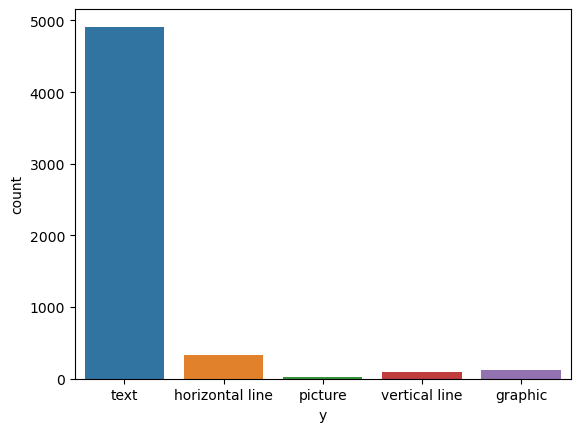

In [5]:
ax=sns.countplot(df['y'])
ax.set(xticklabels=output_dict.values())
plt.show()

In [6]:
X=df.iloc[:, :-1]
y=df['y']

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
y_train.value_counts()

3    3945
4    3938
5    3924
1    3923
2    3922
Name: y, dtype: int64

In [9]:
#suppot vector classifier
svm = SVC()
params= {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear']
             } 

In [10]:
random_search = RandomizedSearchCV(svm, params, cv = 5,n_jobs=-1, refit = True, verbose = 3)
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['linear']},
                   verbose=3)

In [11]:
print(f"The best hyperparameters: {random_search.best_params_}")
print(f"The best score: {random_search.best_score_}")

The best hyperparameters: {'kernel': 'linear', 'gamma': 1, 'C': 1000}
The best score: 0.9572053288177811


In [12]:
print(random_search.best_estimator_)

SVC(C=1000, gamma=1, kernel='linear')


# Linear SVM 

In [13]:
model1 = SVC(kernel=random_search.best_params_['kernel'], C=random_search.best_params_['C'],
             gamma=random_search.best_params_['gamma'])
model1.fit(X_train_scaled, y_train)

SVC(C=1000, gamma=1, kernel='linear')

In [14]:
y_pred=model1.predict(X_test_scaled)

In [15]:
accuracy_score(y_test,y_pred)

0.9554243842865866

In [16]:
cv_scores = cross_val_score(model1, 
                            X_train_scaled, 
                            y_train, 
                            cv=KFold(n_splits=10, shuffle=True),
                            scoring='accuracy')

cv_scores

array([0.95218718, 0.95116989, 0.95419847, 0.95979644, 0.96234097,
       0.95928753, 0.96081425, 0.9562341 , 0.95572519, 0.956743  ])

Average Accuracy 0.9568497019302701
Standard deviation of Accuracy 0.0035097174102733564


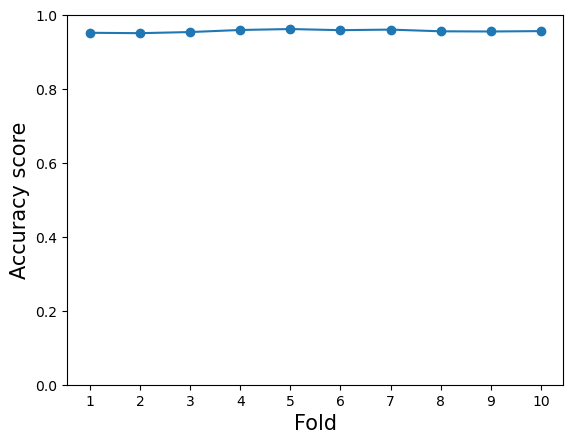

In [17]:
plt.plot(range(1, 11), cv_scores, marker='o')
plt.ylim(0, 1)
plt.ylabel('Accuracy score', fontsize=15)
plt.xlabel('Fold', fontsize=15)
plt.xticks(range(1,11))
print("Average Accuracy",cv_scores.mean())
print("Standard deviation of Accuracy",cv_scores.std())

In [18]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[900,  27,   2,  13,  48],
       [ 19, 937,   0,  17,  18],
       [  0,   0, 968,   0,   0],
       [  9,  13,   0, 953,   0],
       [ 32,  11,   0,  10, 936]])

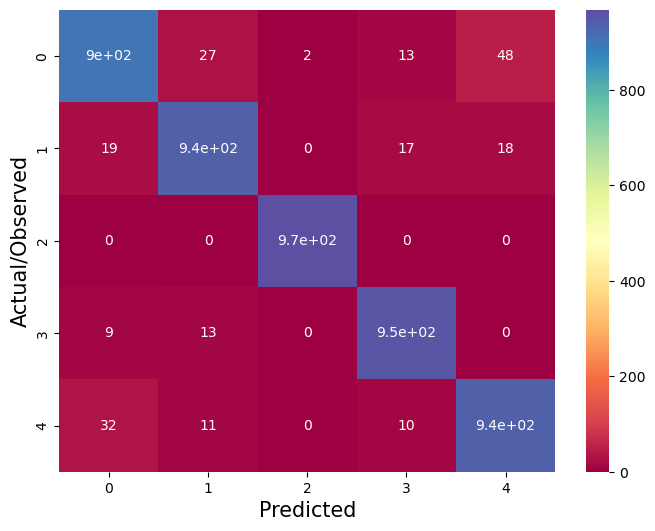

In [19]:
plt.figure(figsize = (8,6))

sns.heatmap(cm, 
            annot=True, 
            cmap="Spectral")
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual/Observed', fontsize=15);

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.94      0.91      0.92       990
           2       0.95      0.95      0.95       991
           3       1.00      1.00      1.00       968
           4       0.96      0.98      0.97       975
           5       0.93      0.95      0.94       989

    accuracy                           0.96      4913
   macro avg       0.96      0.96      0.96      4913
weighted avg       0.96      0.96      0.96      4913



# Deep Learning using MLP Classifier

In [21]:
model4= MLPClassifier()
param_grid = {
    'hidden_layer_sizes': [(100,), (200,), (500,), (1000,)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}
clf = RandomizedSearchCV(model4, param_grid)
clf.fit(X_train_scaled,y_train)

[CV 1/5] END ..C=1, gamma=0.0001, kernel=linear;, score=0.946 total time=   5.4s
[CV 1/5] END ....C=1000, gamma=1, kernel=linear;, score=0.962 total time=  15.0s
[CV 4/5] END C=1000, gamma=0.0001, kernel=linear;, score=0.961 total time=  13.4s
[CV 2/5] END ..C=1, gamma=0.0001, kernel=linear;, score=0.936 total time=   5.0s
[CV 5/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.933 total time=   3.1s
[CV 3/5] END C=1000, gamma=0.0001, kernel=linear;, score=0.957 total time=  14.1s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.918 total time=   3.7s
[CV 5/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.952 total time=   2.2s
[CV 1/5] END ..C=100, gamma=0.01, kernel=linear;, score=0.962 total time=   3.7s
[CV 2/5] END ......C=10, gamma=1, kernel=linear;, score=0.949 total time=   2.0s
[CV 1/5] END ..C=10, gamma=0.001, kernel=linear;, score=0.962 total time=   4.4s
[CV 5/5] END ..C=10, gamma=0.001, kernel=linear;, score=0.952 total time=   2.6s
[CV 3/5] END ....C=1000, g

RandomizedSearchCV(estimator=MLPClassifier(),
                   param_distributions={'activation': ['relu', 'logistic'],
                                        'alpha': [0.0001, 0.001, 0.01],
                                        'hidden_layer_sizes': [(100,), (200,),
                                                               (500,),
                                                               (1000,)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['adam', 'sgd']})

In [22]:
clf.best_params_

{'solver': 'adam',
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (1000,),
 'alpha': 0.0001,
 'activation': 'relu'}

In [23]:
clf = MLPClassifier(solver = clf.best_params_['solver'],learning_rate = clf.best_params_['learning_rate'],
                    hidden_layer_sizes = clf.best_params_['hidden_layer_sizes'],
                    alpha = clf.best_params_['alpha'],
                    activation = clf.best_params_["activation"])
clf.fit(X_train_scaled,y_train)

MLPClassifier(hidden_layer_sizes=(1000,), learning_rate='adaptive')

In [24]:
y_pred=clf.predict(X_test_scaled)

In [25]:
accuracy_score(y_test,y_pred)

0.9857520863016487

In [26]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[959,  10,   2,   4,  15],
       [  4, 962,   0,  14,  11],
       [  0,   0, 968,   0,   0],
       [  0,   0,   0, 975,   0],
       [  0,   0,   0,  10, 979]])

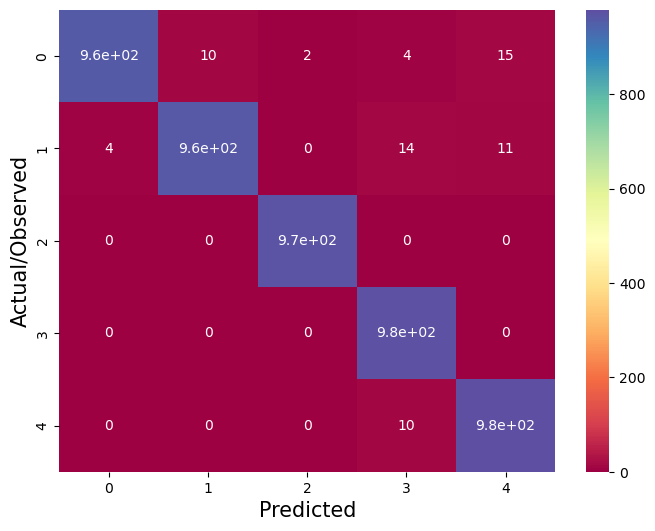

In [27]:
plt.figure(figsize = (8,6))

sns.heatmap(cm, 
            annot=True, 
            cmap="Spectral")
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual/Observed', fontsize=15);

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.97      0.98       990
           2       0.99      0.97      0.98       991
           3       1.00      1.00      1.00       968
           4       0.97      1.00      0.99       975
           5       0.97      0.99      0.98       989

    accuracy                           0.99      4913
   macro avg       0.99      0.99      0.99      4913
weighted avg       0.99      0.99      0.99      4913



In [29]:
cv_scores = cross_val_score(clf, 
                            X_train_scaled, 
                            y_train, 
                            cv=KFold(n_splits=10, shuffle=True),
                            scoring='accuracy')

cv_scores

array([0.98626653, 0.98474059, 0.98320611, 0.98982188, 0.98676845,
       0.98320611, 0.98982188, 0.99033079, 0.98422392, 0.98422392])

Average Accuracy 0.9862610174493099
Standard deviation of Accuracy 0.002673130778782335


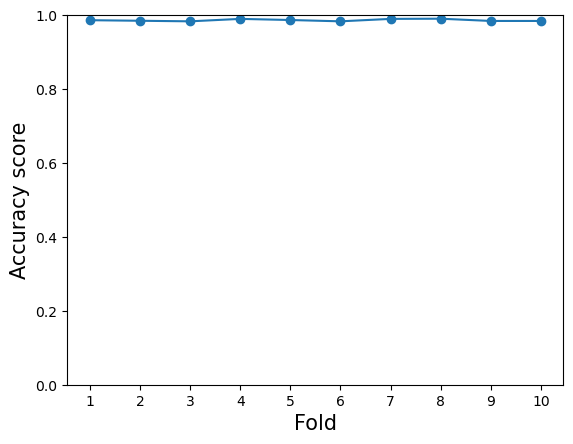

In [30]:
plt.plot(range(1, 11), cv_scores, marker='o')
plt.ylim(0, 1)
plt.ylabel('Accuracy score', fontsize=15)
plt.xlabel('Fold', fontsize=15)
plt.xticks(range(1,11))
print("Average Accuracy",cv_scores.mean())
print("Standard deviation of Accuracy",cv_scores.std())

# Extreme learning Machines

In [31]:
from skelm import ELMClassifier
from itertools import product

class ELMGridSearch:
    def __init__(self, param_grid,cv=5):
        self.param_grid = param_grid
        self.cv = cv
        
    def fit(self, X_train, y_train):
        best_score = 0
        best_params = None
        
        n_samples = X_train.shape[0]
        fold_size = n_samples // self.cv
        
        for params in product(*self.param_grid.values()):
            params = dict(zip(self.param_grid.keys(), params))
            clf = ELMClassifier(**params)
            clf.fit(X_train, y_train)
            # Perform manual cross-validation
            scores = []
            for fold in range(self.cv):
                start = fold * fold_size
                end = start + fold_size
                
                # Split data into training and validation folds
                X_val = X_train[start:end]
                y_val = y_train[start:end]
                X_tr = np.concatenate((X_train[:start], X_train[end:]))
                y_tr = np.concatenate((y_train[:start], y_train[end:]))
                
                # Train the model on the training fold
                clf.fit(X_tr, y_tr)
                
                # Evaluate the model on the validation fold
                score = clf.score(X_val, y_val)
                scores.append(score)
                
            # Compute the average performance across all folds
            score = np.mean(scores)
            
            
            if score > best_score:
                best_score = score
                best_params = params
        
        self.best_params_ = best_params
        self.best_score_ = best_score
        self.best_estimator_ = ELMClassifier(**best_params)
        self.best_estimator_.fit(X_train, y_train)
        
        return self
        
    def predict(self, X_test):
        return self.best_estimator_.predict(X_test)
param_grid = {
    'n_neurons': [100, 200, 300,400,512,1000],
    'ufunc': [ 'relu','tanh'],
    'alpha': [0.001, 0.01, 0.1]
}

search = ELMGridSearch(param_grid,cv=5)
search.fit(X_train_scaled, y_train)

print(search.best_params_)
print(search.best_score_)

{'n_neurons': 1000, 'ufunc': 'relu', 'alpha': 0.001}
0.9814249363867684


In [32]:
model3 = ELMClassifier(n_neurons = search.best_params_['n_neurons'],ufunc = search.best_params_['ufunc'],
                    alpha = search.best_params_['alpha'])
model3.fit(X_train_scaled,y_train)

ELMClassifier(alpha=0.001, n_neurons=1000, ufunc='relu')

In [33]:
y_pred=model3.predict(X_test_scaled)

In [34]:
accuracy_score(y_test,y_pred)

0.979849379198046

In [35]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[947,  12,   2,   9,  20],
       [  4, 958,   0,  17,  12],
       [  0,   0, 968,   0,   0],
       [  0,  13,   0, 962,   0],
       [  0,   0,   0,  10, 979]])

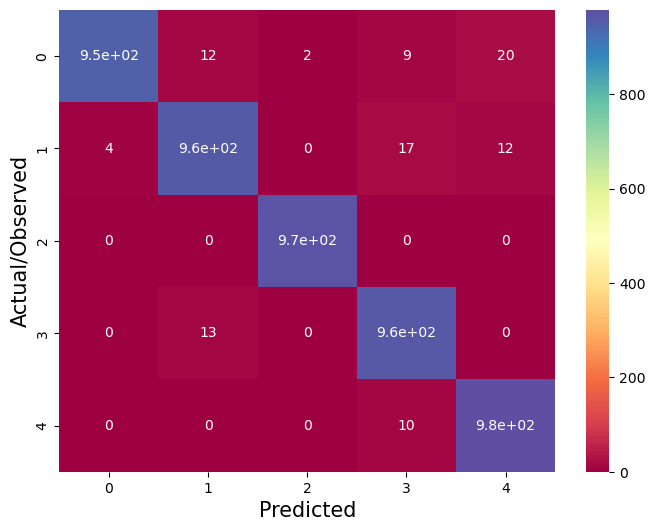

In [36]:
plt.figure(figsize = (8,6))

sns.heatmap(cm, 
            annot=True, 
            cmap="Spectral")
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual/Observed', fontsize=15);

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.96      0.98       990
           2       0.97      0.97      0.97       991
           3       1.00      1.00      1.00       968
           4       0.96      0.99      0.98       975
           5       0.97      0.99      0.98       989

    accuracy                           0.98      4913
   macro avg       0.98      0.98      0.98      4913
weighted avg       0.98      0.98      0.98      4913



In [38]:
n_folds = 10
fold_size = X_train_scaled.shape[0] // n_folds
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(n_folds)]

scores = []
for i in range(n_folds):
    
    
    # Get the training and validation data for this fold
    val_start, val_end = folds[i]
    X_val = X_train_scaled[val_start:val_end]
    y_val = y_train[val_start:val_end]
    X_trn = np.concatenate((X_train_scaled[:val_start], X_train_scaled[val_end:]), axis=0)
    y_trn = np.concatenate((y_train[:val_start], y_train[val_end:]), axis=0)
    
    # Train the ELMClassifier
    
    model3.fit(X_trn, y_trn)
    
    # Evaluate the ELMClassifier on the validation data
    score = clf.score(X_val, y_val)
    scores.append(score)
scores

[0.9857506361323155,
 0.9933842239185751,
 0.983206106870229,
 0.9867684478371501,
 0.9872773536895675,
 0.9923664122137404,
 0.9857506361323155,
 0.9928753180661578,
 0.9852417302798983,
 0.9867684478371501]

Average Accuracy 0.98793893129771
Standard deviation of Accuracy 0.003406629612453856


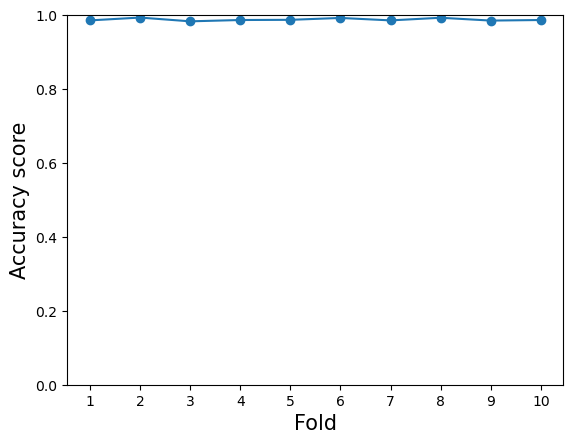

In [39]:
plt.plot(range(1, 11), scores, marker='o')
plt.ylim(0, 1)
plt.ylabel('Accuracy score', fontsize=15)
plt.xlabel('Fold', fontsize=15)
plt.xticks(range(1,11))
print("Average Accuracy",np.array(scores).mean())
print("Standard deviation of Accuracy",np.array(scores).std())